# Importación de Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from sklearn.metrics import accuracy_score
from src.processing.constants import BASE_DIRECTORY
from typing import Dict
from typing import List
from text_complexity_analyzer_cm.text_complexity_analyzer import TextComplexityAnalyzer

%matplotlib inline

# Funciones de ayuda

In [2]:
def get_epoch_from_line(line: str) -> int:
    '''
    This function gets an epoch from a line of the text.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    int: The epoch.
    '''
    return int(line.split()[1].split('/')[0])

In [3]:
def get_training_loss_from_line(line: str) -> float:
    '''
    This function gets the training loss from a line.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    float: The training loss.
    '''
    words = line.split()
    training_loss_str = words[11]
    return float(training_loss_str[:-1])

In [4]:
def get_validation_loss_from_line(line: str) -> float:
    '''
    This function gets the validation loss from a line.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    float: The validation loss.
    '''
    words = line.split()
    validation_loss_str = words[4]
    return float(validation_loss_str[:-1])

In [5]:
def get_training_validation_perplexity(filename: str, epochs: int) -> (List, List):
    '''
    This function obtains, from a text file, the validation and training perplexity.
    
    Parameters:
    filename(str): The file where the training log of the chatbot is found.
    epochs(str): The amount of epochs that were used to train the chatbot.
    
    Returns:
    List, List: A list with the training loss and another with the validaton perplexity.
    '''
    training_loss = np.zeros(epochs)
    validation_loss = np.zeros(epochs)
    with open(filename, 'r') as f: # Open the file with the training data
        # Iterate every line
        for line in f:
            if 'Training Loss:' in line: # Get training loss
                epoch = get_epoch_from_line(line) # Get epoch
                training_loss[epoch - 1] = get_training_loss_from_line(line) # Store loss in list
            elif 'Validation loss:' in line: # Get validation loss
                epoch = get_epoch_from_line(line) # Get epoch)
                validation_loss[epoch - 1] = get_validation_loss_from_line(line) # Store loss in list
    
    return pd.DataFrame(data={
    'training': np.exp(training_loss),
    'validation': np.exp(validation_loss)
    })

In [6]:
def obtain_chatbot_responses(filename: str) -> List[str]:
    '''
    This function reads the log file for the chatbot conversation and obtains the responses given by the chatbot and stores it in an array.
    
    Parameters:
    filename(str): The filename that holds the chatbot conversation.
    
    Returns:
    List[str]: The list with the chatbot's responses.
    '''
    responses = []
    with open(filename, 'r') as f:
        # Read each line
        for line in f:
            # Chatbot response
            if 'ChatBot:' in line:
                tokens = line.split('ChatBot:')
                responses.append(tokens[-1].strip())
    
    return responses

In [7]:
def calculate_chatbots_responses_cm_indices(responses: List[str]) -> Dict:
    '''
    This function calculates the coh metrix indices for the responses given by the chatbot.
    
    Parameters:
    responses(List[str]): A list with the chatbot's responses.
    
    Returns:
    Dict: Dictionary that contains 8 Pandas' dataframes that contains each group of coh metrix indices. 
    '''
    tca = TextComplexityAnalyzer('es')
    indices = {}
    indices['Descriptivo'] = pd.DataFrame()
    indices['Legibilidad'] = pd.DataFrame()
    indices['Información de palabras'] = pd.DataFrame()
    indices['Densidad de patrones sintácticos'] = pd.DataFrame()
    indices['Complejidad sintáctica'] = pd.DataFrame()
    indices['Diversidad léxica'] = pd.DataFrame()
    indices['Cohesión referencial'] = pd.DataFrame()
    indices['Conectivos'] = pd.DataFrame()
    indices['Complejidad textual'] = pd.DataFrame()
    # Iterate over all responses up to a certain point
    for i in range(len(responses)):
        # Gather all responses up until i + 1 and join them in a single string.
        responses_joined = '.\n'.join(responses[:i + 1])
        descriptive, word_information, syntactic_pattern, syntactic_complexity, connective, lexical_diversity, readability, referential_cohesion = tca.calculate_all_indices_for_one_text(text=responses_joined, workers=-1)
        # APpend results to dataframes
        indices['Descriptivo'] = indices['Descriptivo'].append(descriptive, ignore_index=True)
        indices['Legibilidad'] = indices['Legibilidad'].append(readability, ignore_index=True)
        indices['Información de palabras'] = indices['Información de palabras'].append(word_information, ignore_index=True)
        indices['Densidad de patrones sintácticos'] = indices['Densidad de patrones sintácticos'].append(syntactic_pattern, ignore_index=True)
        indices['Complejidad sintáctica'] = indices['Complejidad sintáctica'].append(syntactic_complexity, ignore_index=True)
        indices['Diversidad léxica'] = indices['Diversidad léxica'].append(lexical_diversity, ignore_index=True)
        indices['Cohesión referencial'] = indices['Cohesión referencial'].append(referential_cohesion, ignore_index=True)
        indices['Conectivos'] = indices['Conectivos'].append(connective, ignore_index=True)
        indices['Complejidad textual'] = indices['Complejidad textual'].append({
            'Categoria': tca.predict_text_category(text=responses_joined, workers=-1)[-1]
        }, ignore_index=True)
    
    return indices

In [8]:
def draw_indices(indices: Dict) -> None:
    '''
    This funciton draws all the indices using lineplots and a boxplot for the predictions.
    
    Parameters:
    indices(Dict): Dictionary that containes the 8 pandas dataframes with the indices.
    
    Returns:
    None.
    '''
    # Iterate over all keys from the dictionary
    for key in indices.keys():
        # Draw figure
        plt.figure(figsize=(15, 7))
        if key != 'Complejidad textual':
            sns.lineplot(data=indices[key])
            plt.title(f'Indices {key}')
            plt.ylabel('Valor de índice')
            plt.xlabel('Cantidad de respuestas de chatbot')
        else:
            sns.countplot(x='Categoria', data=indices[key])
            plt.ylabel('Cantidad')
            plt.xlabel('Categoría')
            plt.title(key)
        
    plt.show()

In [9]:
def predicted_text_statistic_analysis_2(textual_complexity, predictions: pd.DataFrame, mean: float, tail: str='upper', alpha: float=0.05) -> None:
    total_mean = predictions['Categoria'].mean() # Calculate mean of population
    std = predictions['Categoria'].std() # Calculate std of population
    p_value = (1 - alpha / 2) if tail == 'two' else (1 - alpha) # Get p value
    z_score = scipy.stats.norm.ppf(p_value) # Calculate z score for p value
    z_0 = (total_mean - mean) / predictions['Categoria'].sem() # Calculate z test
    print(f'El valor Z_{p_value} es: {z_score}.')
    print(f'El valor Z_0 es {z_0}.')
    # Test hypothesis
    if tail == 'upper':
        if z_0 > z_score:
            print(f'Se rechaza la hipótesis nula. La media es {total_mean}')
        else:
            print(f'No hay suficientes pruebas para rechazar la hipótesis nula. La media es {total_mean}.')
    elif tail == 'lower':
        if z_0 < z_score:
            print(f'Se rechaza la hipótesis nula. La media es {total_mean}')
        else:
            print(f'No hay suficientes pruebas para rechazar la hipótesis nula. La media es {total_mean}.')
    elif tail == 'two':
        if (z_0 > z_score) or (z_0 < (-1 * z_score)):
            print(f'Se rechaza la hipótesis nula. La media es {total_mean}')
        else:
            print(f'No hay suficientes pruebas para rechazar la hipótesis nula. La media es {total_mean}.')
    else:
        pass
    # Test mode
    mode = predictions['Categoria'].mode()[0]
    if mode == textual_complexity:
        print(f'La moda {mode} es igual a la complejidad textual {textual_complexity}.')
    else:
        print(f'La moda {mode} no es igual a la complejidad textual {textual_complexity}.')
    # Test accuracy
    expected_complexity = [textual_complexity for i in range(len(predictions))]
    accuracy = accuracy_score(expected_complexity, predictions['Categoria'])
    print(f'La exactitud de las predicciones es de {accuracy * 100}%.')
    

# Experimento usando los documentos de Comunicación

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [10]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_1_comunicacion.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.000000
mean,217.391494,386.721382
std,264.319543,236.103218
min,5.275112,148.561646
25%,16.942554,177.206910
50%,65.883795,261.283264
75%,367.165588,617.244908
max,1065.287506,929.828351


#### Curva de error: Capacidad de comprensión

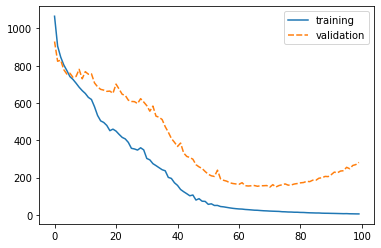

In [11]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error, también conocido como Perplexity, el cual indica la capacidad de comprensión del Chatbot, es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [128]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_comunicacion_chat.txt')
print(chatbot_responses)

['publico mi texto en un lugar del aula que el docente indique', 'para realizar tu texto informativo debes seguir las pasos', 'organiza los pasos', 'y completa sus ideas', 'el texto y la forma de la siguiente página', 'este texto de la siguiente unidad', 'el texto de la siguiente página', 'actividad sobre un compañero las alternativas y responde oralmente', 'la siguiente información y responde la información', 'portafolio tu respuesta con tus compañeras y compañeros', 'información con un compañero sobre las situaciones y dialoguen en tu región a partir de las siguientes preguntas leer el diálogo de las palabras palabras las palabras y el texto de las páginas y', 'completa un esquema sobre la que se indica una una de una unidad sobre cómo la vida diaria', 'para ello tu respuesta', 'para elaborar sobre las compañeras y compañeros sobre lo que aprenderemos expresar sobre el cuidado del ambiente', 'leer un texto y reconocer los pasos y su estructura', 'para qué leerás a realizar este texto

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [129]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 10.152865886688232 seconds.
Text analyzed in 10.440661191940308 seconds.
Text analyzed in 10.799360275268555 seconds.
Text analyzed in 11.444777011871338 seconds.
Text analyzed in 13.881834745407104 seconds.
Text analyzed in 12.852390766143799 seconds.
Text analyzed in 13.187340497970581 seconds.
Text analyzed in 14.485422372817993 seconds.
Text analyzed in 11.822655200958252 seconds.
Text analyzed in 12.837687492370605 seconds.
Text analyzed in 13.120381832122803 seconds.
Text analyzed in 13.145113229751587 seconds.
Text analyzed in 12.450490951538086 seconds.
Text analyzed in 13.643526554107666 seconds.
Text analyzed in 12.094911575317383 seconds.
Text analyzed in 12.207025527954102 seconds.
Text analyzed in 12.220506429672241 seconds.
Text analyzed in 11.735321760177612 seconds.
Text analyzed in 12.272467374801636 seconds.
Text analyzed in 12.132729291915894 seconds.
Text analyzed in 13.362261533737183 seconds.
Text analyzed in 13.723888874053955 seconds.
Text analy

#### Graficando los índices y complejidad textual

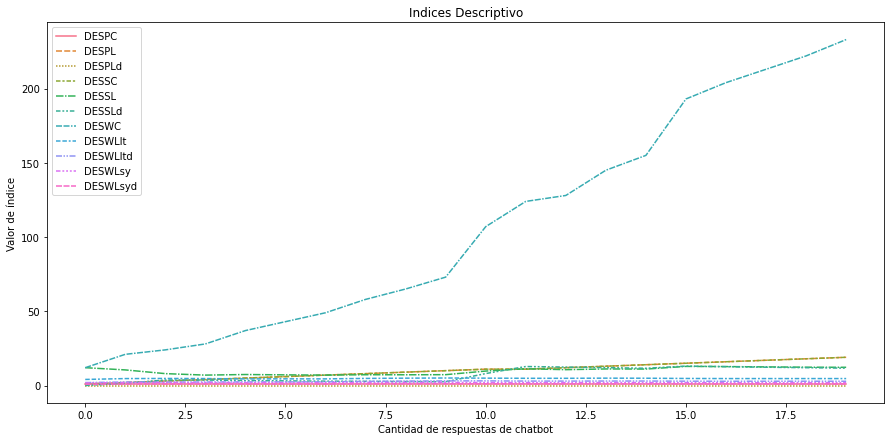

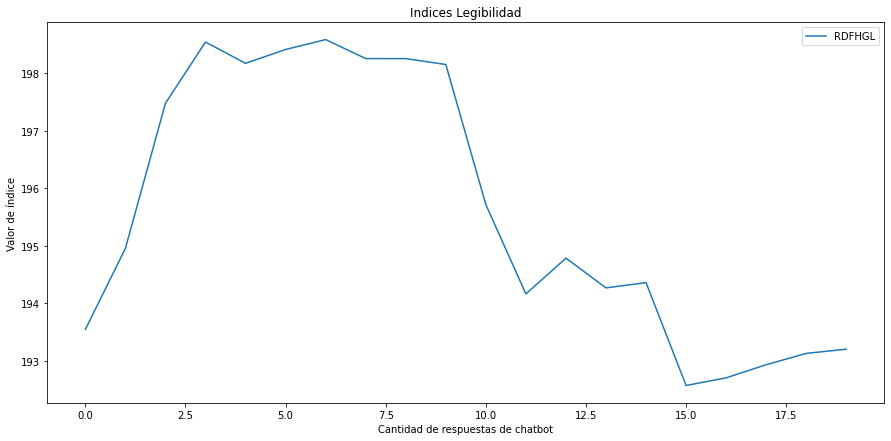

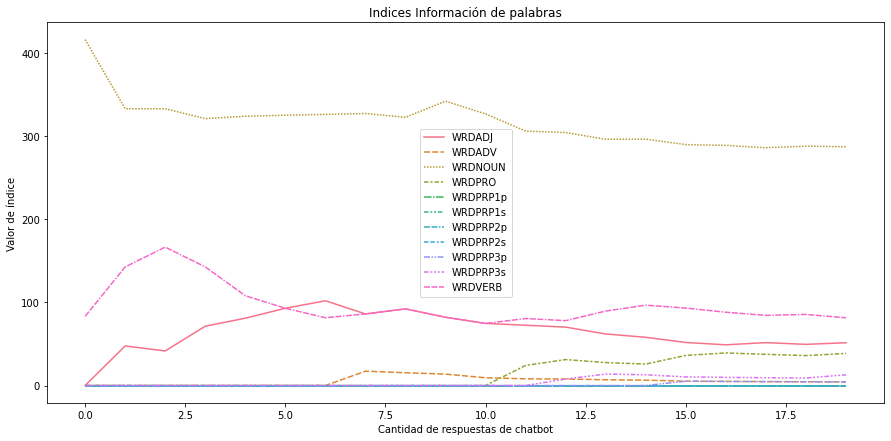

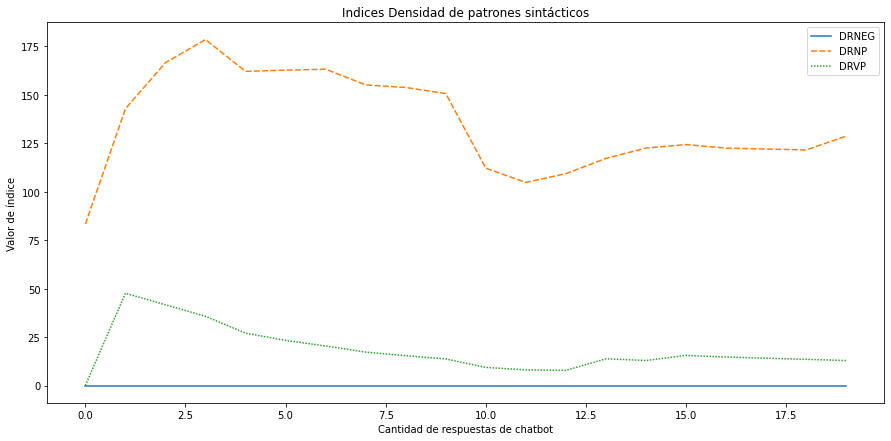

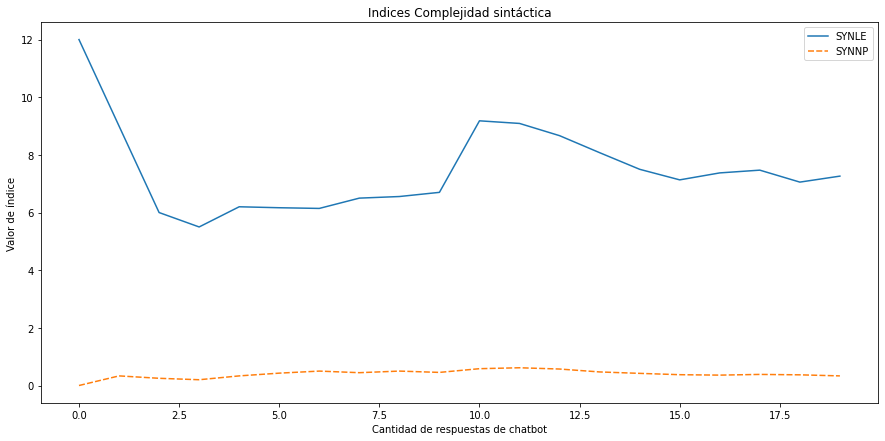

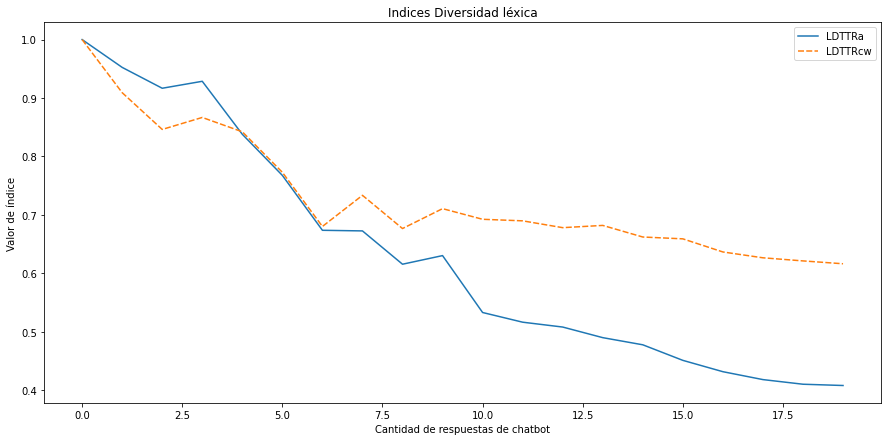

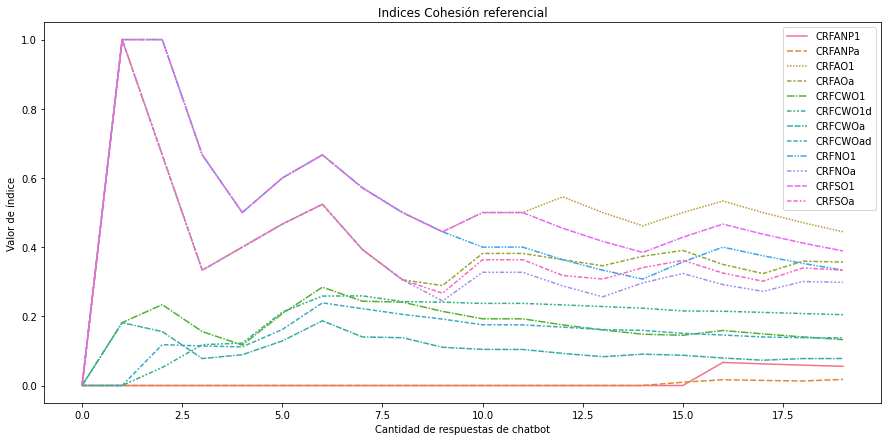

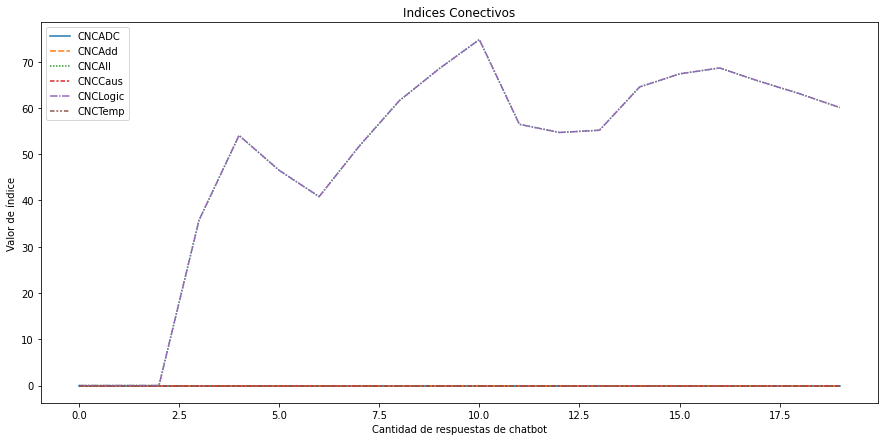

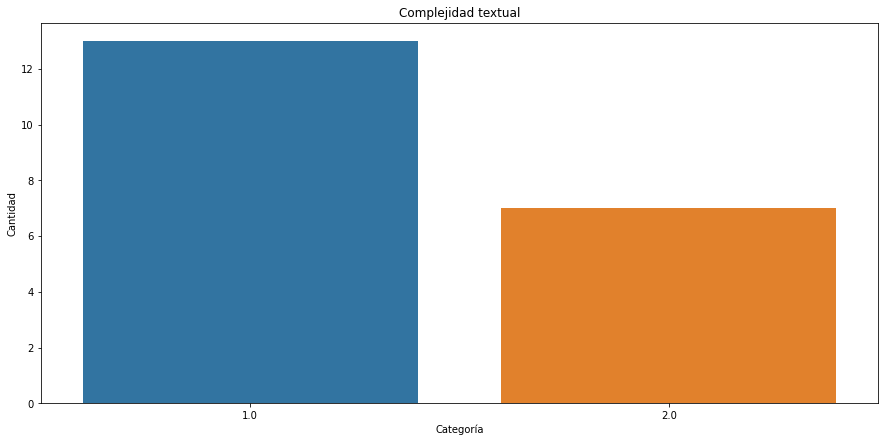

In [130]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \leq 1.5 \\
\ H_1 > 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [131]:
predicted_text_statistic_analysis_2(textual_complexity=1, predictions=indices['Complejidad textual'], mean=1.5, tail='upper', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es -1.3708103001950622.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.35.
La moda 1.0 es igual a la complejidad textual 1.
La exactitud de las predicciones es de 65.0%.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 1, la cual es la la complejidad textual más simple y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 1. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [16]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_2_comunicacion.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.000000
mean,651.013289,972.303613
std,397.528091,294.046973
min,126.090512,513.885254
25%,268.081556,658.732830
50%,561.999031,947.675837
75%,1034.580019,1232.746641
max,1520.812484,1629.453563


#### Curva de error: Capacidad de comprensión

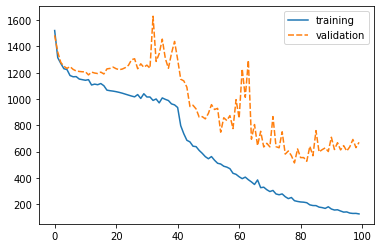

In [17]:
sns.lineplot(data=losses)
plt.show()

Se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Además, la media ni la desviación estándar pueden ser utilizadas debido a los valores atípicos en el conjunto de validación, representado por la inesperada punta durante la época 20. También, analizando la gráfica, se observa que el Chatbot aprende un poco rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [90]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_comunicacion_chat.txt')
print(chatbot_responses)

['o exagerar partes de la historia o características de algún personaje', 'comunicacio n er taller de lectura taller de lectura el encanto de las palabras escribe en lo que viene del texto de las y las estudiantes de su interés', 'condiciones previas preguntar si alguno de los estudiantes cumplió con el reto familiar y socializar su experiencia', 'los textos que se trabajarán en este cuarto son corresponden al tercer bloque del siguiente bloque de la antología literaria y se enmarcan en una diversidad de géneros y una', 'en esta sesión se continúa con la lectura de la sesión anterior', 'condiciones previas seleccionar si alguno de los estudiantes cumplió con el reto familiar y socializar su experiencia', 'el texto de la sesión es de manera por qué es del segundo bloque del texto de los y las estudiantes se debe situaciones una ruta de los estudiantes literarias', 'el texto de la sesión es el texto de la sesión anterior', 'el texto seleccionado se organiza en la sesión y', 'a continuaci

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [91]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 6.482064247131348 seconds.
Text analyzed in 6.228224992752075 seconds.
Text analyzed in 6.26222825050354 seconds.
Text analyzed in 6.254087209701538 seconds.
Text analyzed in 6.220448732376099 seconds.
Text analyzed in 6.228482961654663 seconds.
Text analyzed in 6.2671215534210205 seconds.
Text analyzed in 6.2147486209869385 seconds.
Text analyzed in 6.253077030181885 seconds.
Text analyzed in 6.2819318771362305 seconds.
Text analyzed in 6.286824464797974 seconds.
Text analyzed in 6.3447699546813965 seconds.
Text analyzed in 6.270390272140503 seconds.
Text analyzed in 6.325724124908447 seconds.
Text analyzed in 6.3121795654296875 seconds.
Text analyzed in 6.312375545501709 seconds.
Text analyzed in 6.270979642868042 seconds.
Text analyzed in 6.31084132194519 seconds.
Text analyzed in 6.341846942901611 seconds.
Text analyzed in 6.758790016174316 seconds.
Text analyzed in 6.570563077926636 seconds.
Text analyzed in 6.36208963394165 seconds.
Text analyzed in 6.31137657165

#### Graficando los índices y complejidad textual

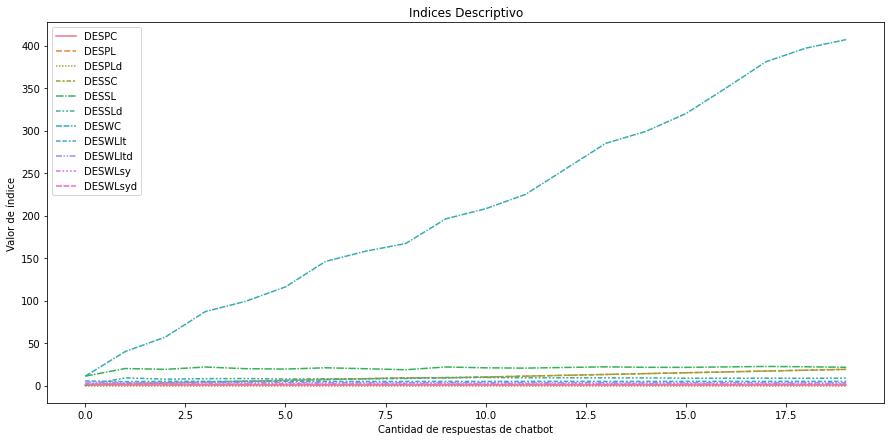

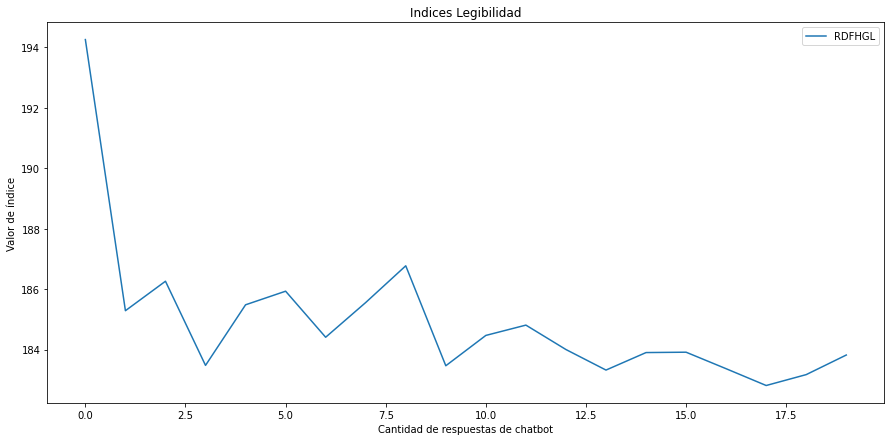

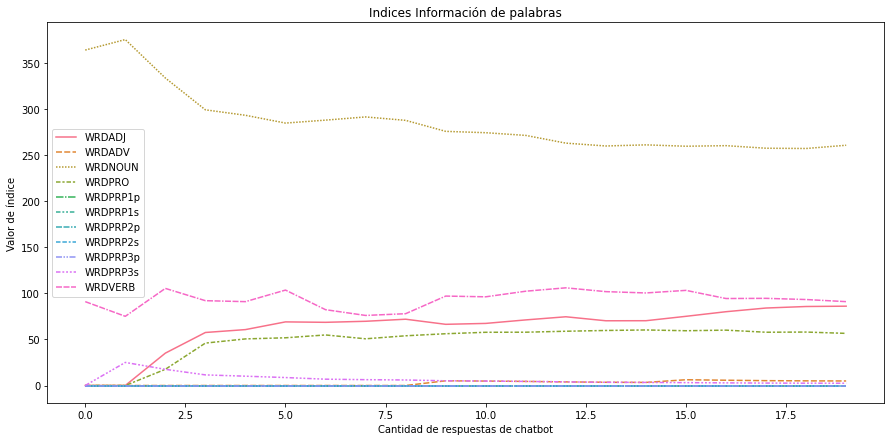

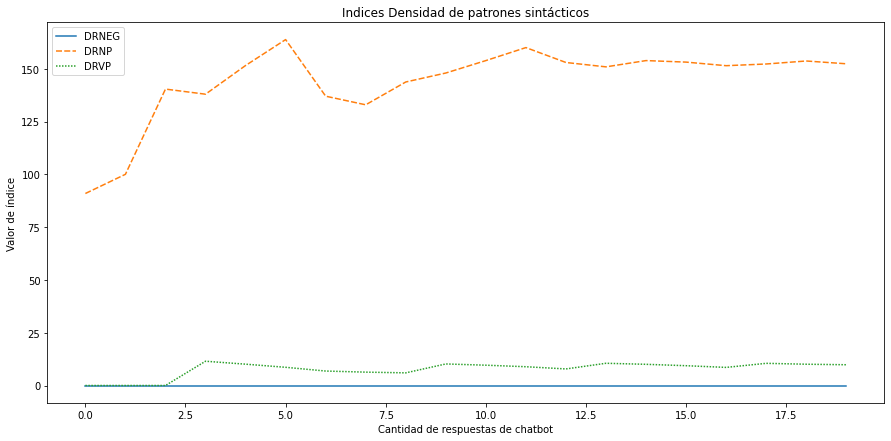

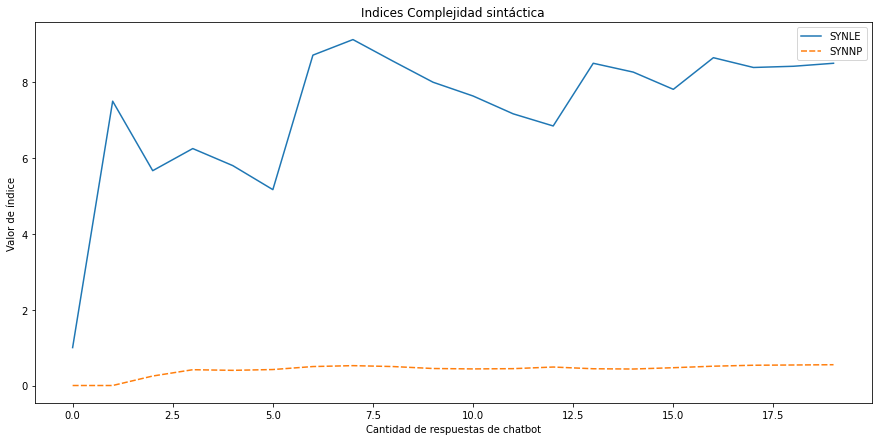

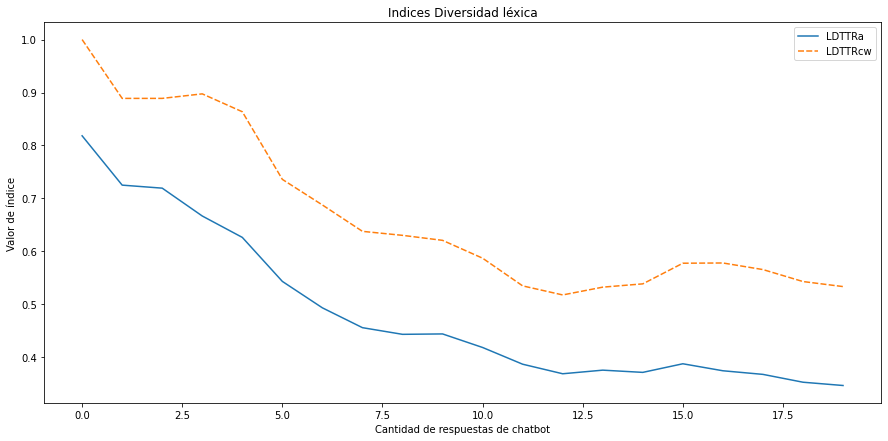

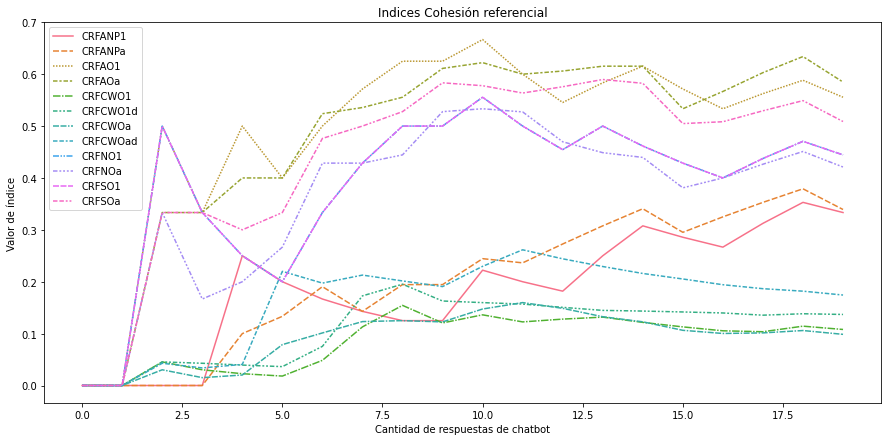

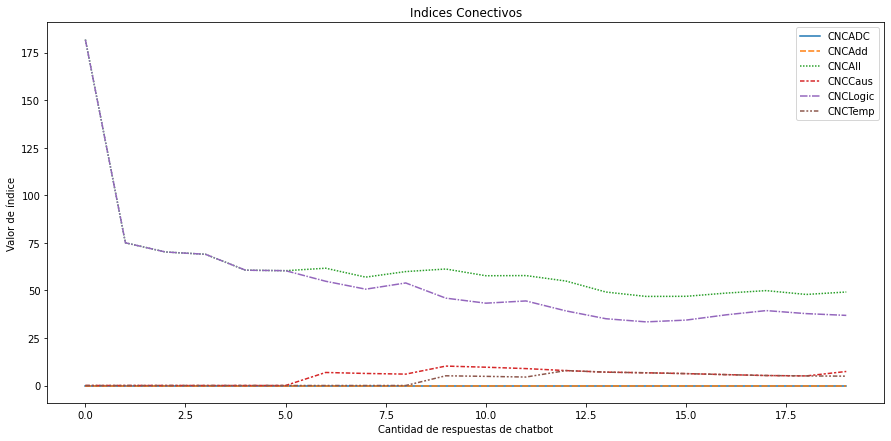

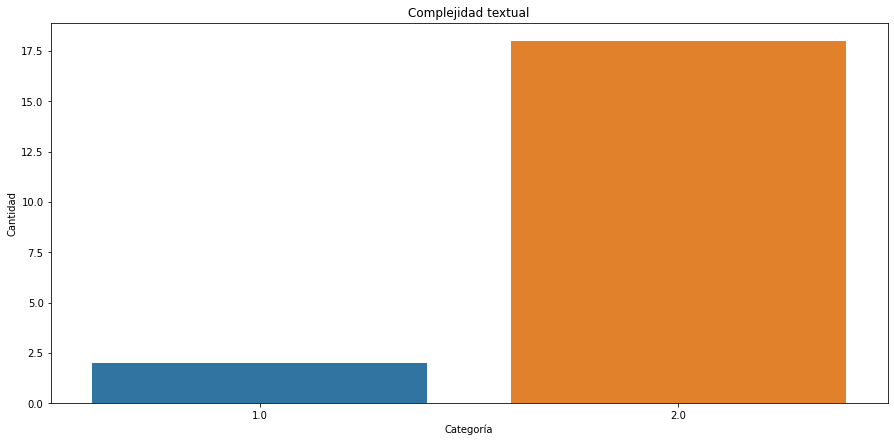

In [92]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea mayor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 2.

\begin{align}
\ H_0 \geq 1.5 \\
\ H_1 < 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 2 en este caso.

In [93]:
predicted_text_statistic_analysis_2(textual_complexity=2, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 5.811865258054231.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.9.
La moda 2.0 es igual a la complejidad textual 2.
La exactitud de las predicciones es de 90.0%.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 2, la cual es la la complejidad textual más compleja y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 2. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.


# Experimento usando los documentos de Ciencia y Tecnología

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [80]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_1_CTA_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,334.306501,2614.210993
std,536.022163,1461.933344
min,2.181472,1320.809387
25%,9.077291,1537.643007
50%,102.613043,1905.529354
75%,541.721668,3335.938604
max,4803.019204,7208.383481


#### Curva de error: Capacidad de comprensión

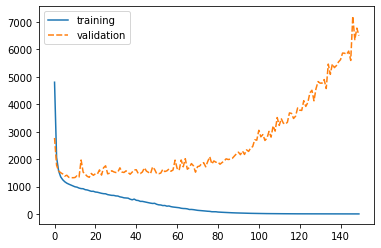

In [81]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [86]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_cta_150_chat.txt')
print(chatbot_responses)

['c u a d e r n o d e t r a b a j o I v c I c l o º y º g r a', 'amigas y amigos energía actividades alemana rayos rayos rayos für internationale zusammenarbeit giz colector colector desarrollo desarrollo y vida endev pasaje maría maría piso piso san lima I I I', 'ahorrar indica y energía energía forma', 'amigas electricidad electricidad energía y importante importante y salud', 'amigas y compañeros y tecnologia actividad forma actividad esquema actividad respondemos a actividad actividad utilizaremos', 'ahorrar preguntas energía energía energía y importante importante y amigos eléctrica salud y salud salud', 'amigas y compañeros energía forma forma forma agua y amigos importante', 'ahorrar ahorrar energía energía energía energía y importante eléctrica eléctrica y actividades actividades', 'amigas electricidad evitar energía energía marea marea y observa observa energía energía', 'electricidad electricidad electricidad energía energía marea y partículas', 'energía electricidad electric

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [87]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 7.138970851898193 seconds.
Text analyzed in 7.608341217041016 seconds.
Text analyzed in 7.489288568496704 seconds.
Text analyzed in 7.666152000427246 seconds.
Text analyzed in 7.571068525314331 seconds.
Text analyzed in 7.850770711898804 seconds.
Text analyzed in 7.570810079574585 seconds.
Text analyzed in 8.741268634796143 seconds.
Text analyzed in 7.4718616008758545 seconds.
Text analyzed in 9.89058542251587 seconds.
Text analyzed in 10.385059118270874 seconds.
Text analyzed in 9.841265201568604 seconds.
Text analyzed in 8.411062717437744 seconds.
Text analyzed in 9.102987051010132 seconds.
Text analyzed in 7.848499298095703 seconds.
Text analyzed in 8.219010591506958 seconds.
Text analyzed in 8.046492338180542 seconds.
Text analyzed in 9.080891132354736 seconds.
Text analyzed in 12.817891120910645 seconds.
Text analyzed in 12.724955320358276 seconds.
Text analyzed in 9.009207487106323 seconds.
Text analyzed in 8.344602584838867 seconds.
Text analyzed in 9.1527516841

#### Graficando los índices y complejidad textual

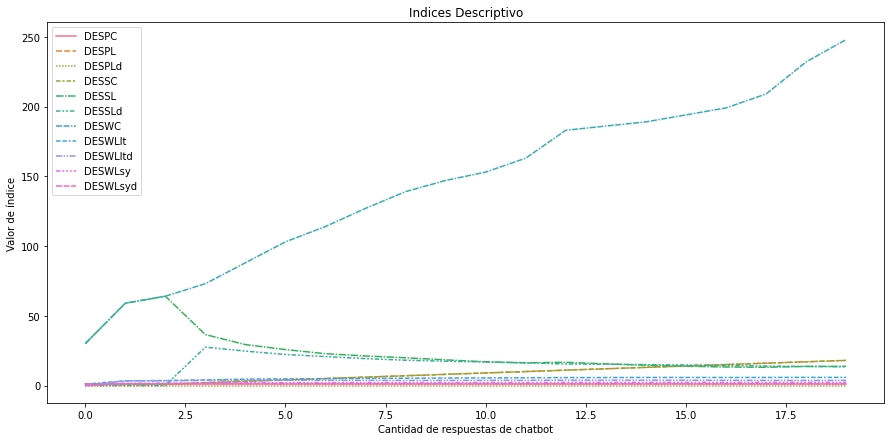

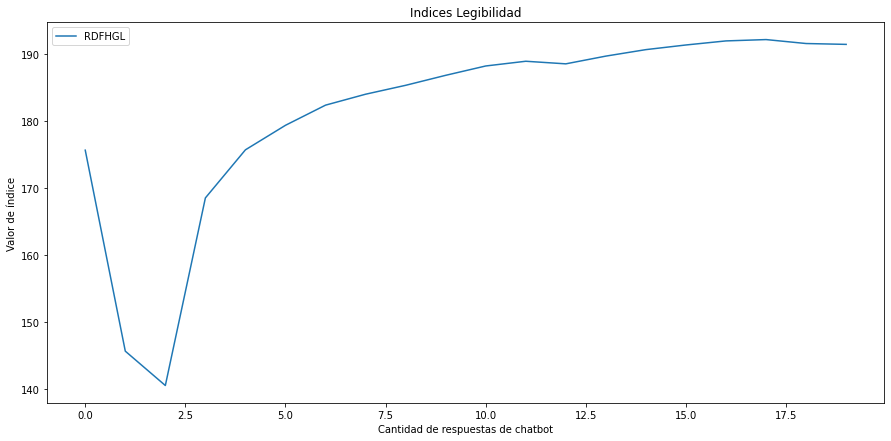

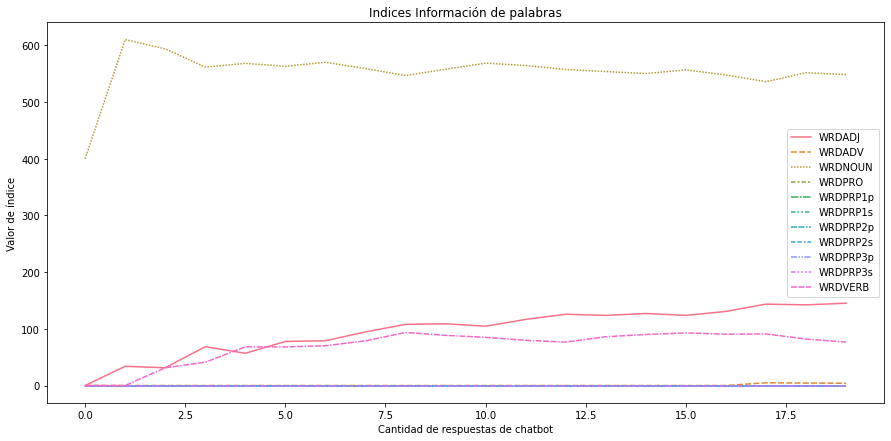

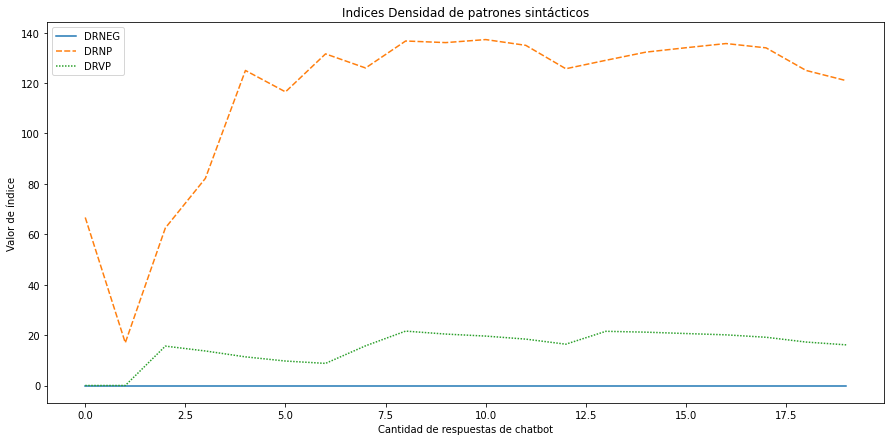

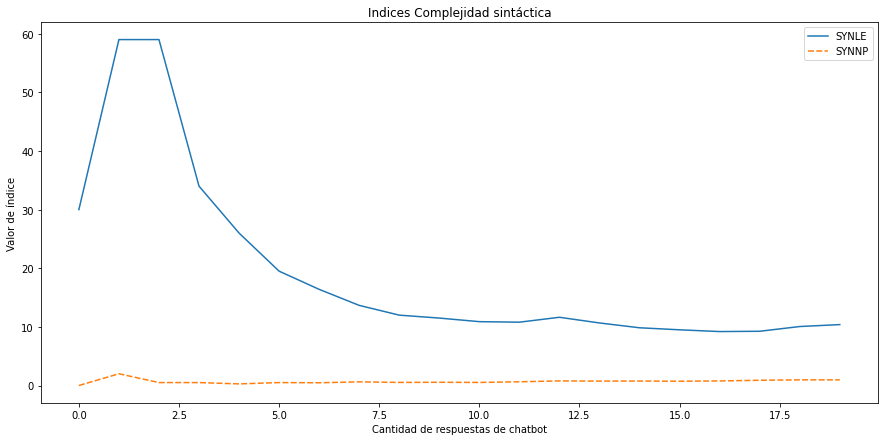

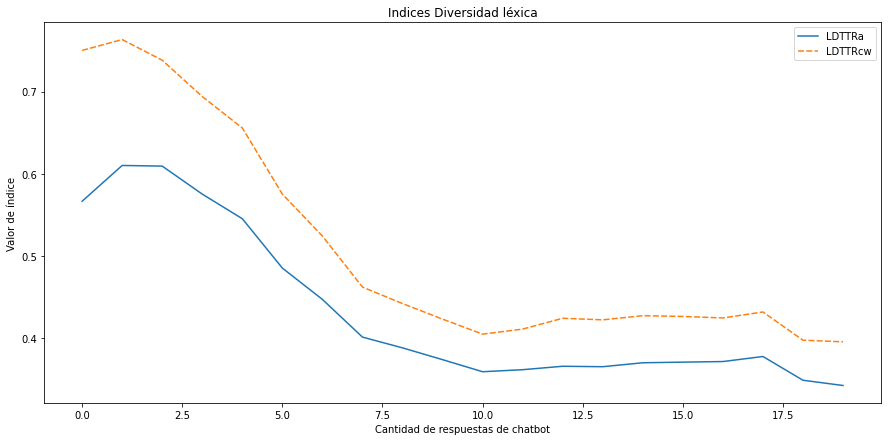

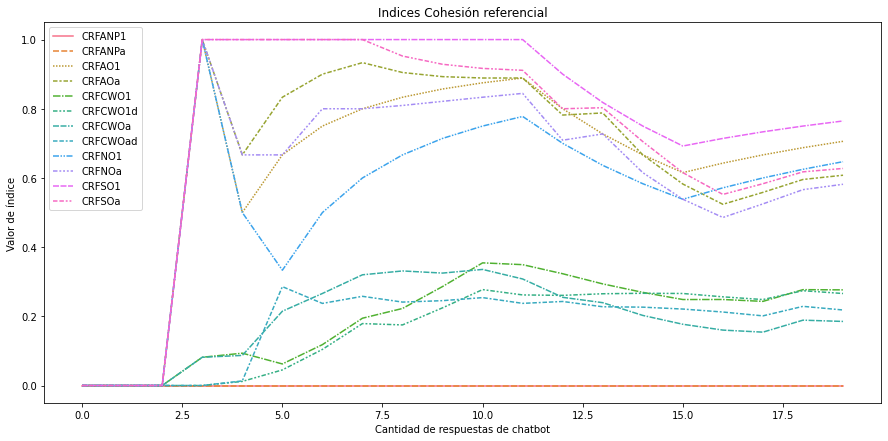

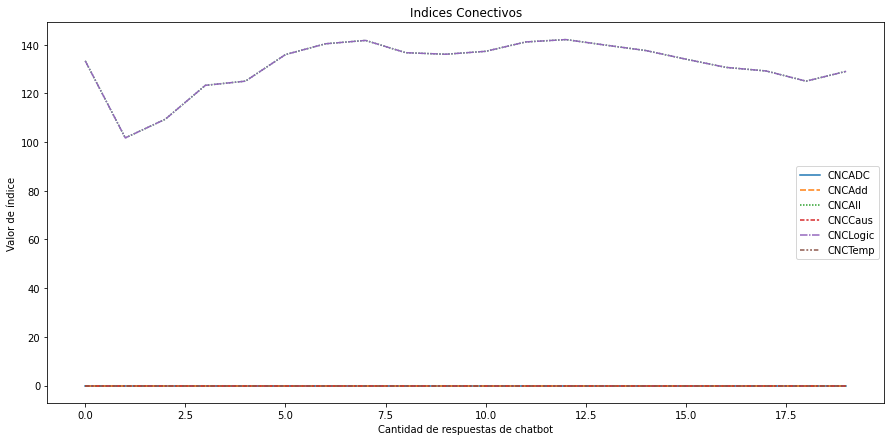

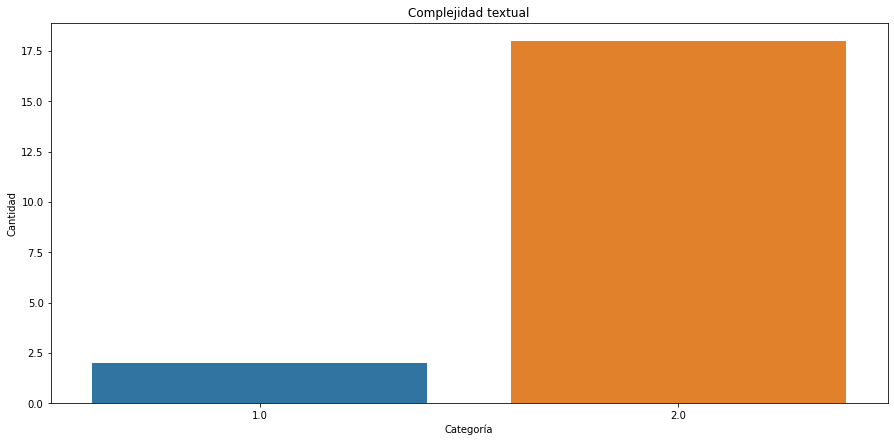

In [88]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \leq 1.5 \\
\ H_1 > 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [89]:
predicted_text_statistic_analysis_2(textual_complexity=1, predictions=indices['Complejidad textual'], mean=1.5, tail='upper', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 5.811865258054231.
Se rechaza la hipótesis nula. La media es 1.9
La moda 2.0 no es igual a la complejidad textual 1.
La exactitud de las predicciones es de 10.0%.


Se observa que, utilizando la moda para encontrar la clase más con las respuestas del chatbot, el nivel de complejidad textual encontrado es de 2, en vez de 1. Ello se debe a que las respuestas del chatbot no son adecuadas, ya que el conjunto de datos provisto no fue tan grande y con ello, el chatbot no pudo descubrir los patrones correctos en los datos para generar respuestas adecuadas.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [68]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_2_CTA_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,466.710441,2244.343024
std,736.357500,864.409371
min,1.525009,1326.103206
25%,6.061376,1590.031952
50%,76.060933,1884.660778
75%,647.778106,2656.480970
max,4242.890340,4731.511564


#### Curva de error: Capacidad de comprensión

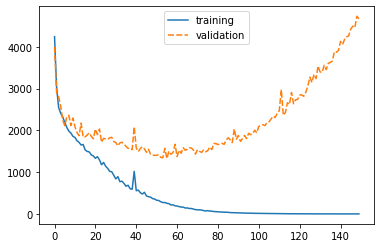

In [69]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación.


#### Obteniendo las respuestas del chatbot

In [76]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_cta_150_chat.txt')
print(chatbot_responses)

['x o m u n ic a c ió n datos personales a foto deberías incluir datos personales consideres importantes nombre y apellidos dirección correo electrónico teléfono enlaces a redes', 'gases llena presente llegar global grasas y partes alto seres y vivos', 'presente presente presente', 'referencia presente', 'actividades', 'tic recomendable', 'presente recomendable y salud examinar crónica fresco o a', 'actividades lee superficie acerca aula organización organización a organización a sangre a investigación investigación investigación correspondiente correspondiente a mental mental a mental c gm gm intencional a prevención hayan hayan hayan', 'nombre nombre y cuya cuya similar organizado', 'material y permite', 'referencia', 'ie a m a a t t m m m t d t o o in in c in is r io d a e d d u c a c ió n at', 'principales ideas exceso exceso cantidad cantidad condiciones cantidad cantidad cantidad información energía información cantidad función función energía energía energía energía energía pesc

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [77]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 5.915581226348877 seconds.
Text analyzed in 5.738466262817383 seconds.
Text analyzed in 6.044168472290039 seconds.
Text analyzed in 5.734863042831421 seconds.
Text analyzed in 5.657201528549194 seconds.
Text analyzed in 5.683575391769409 seconds.
Text analyzed in 5.7422034740448 seconds.
Text analyzed in 5.933151483535767 seconds.
Text analyzed in 6.064149856567383 seconds.
Text analyzed in 6.044660568237305 seconds.
Text analyzed in 6.256829738616943 seconds.
Text analyzed in 6.656653165817261 seconds.
Text analyzed in 7.436385869979858 seconds.
Text analyzed in 5.761114597320557 seconds.
Text analyzed in 6.54014778137207 seconds.
Text analyzed in 11.07752513885498 seconds.
Text analyzed in 11.335129022598267 seconds.
Text analyzed in 8.046542406082153 seconds.
Text analyzed in 8.174809694290161 seconds.
Text analyzed in 8.964374542236328 seconds.
Text analyzed in 7.447757720947266 seconds.
Text analyzed in 5.8629961013793945 seconds.
Text analyzed in 6.28776574134826

#### Graficando los índices y complejidad textual

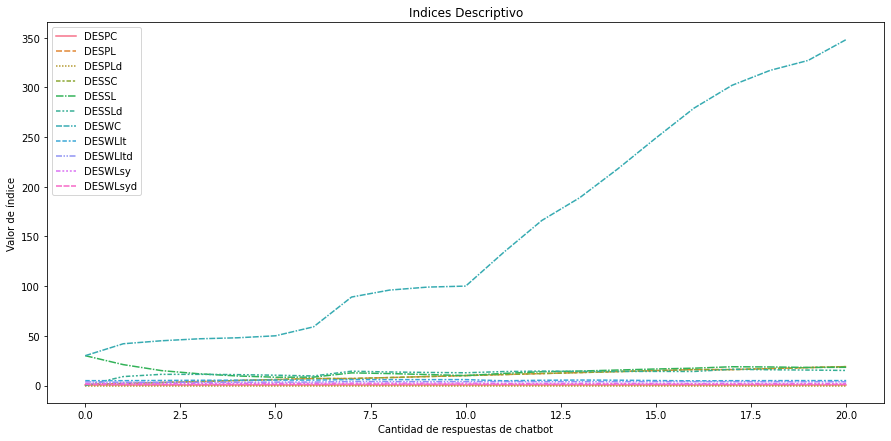

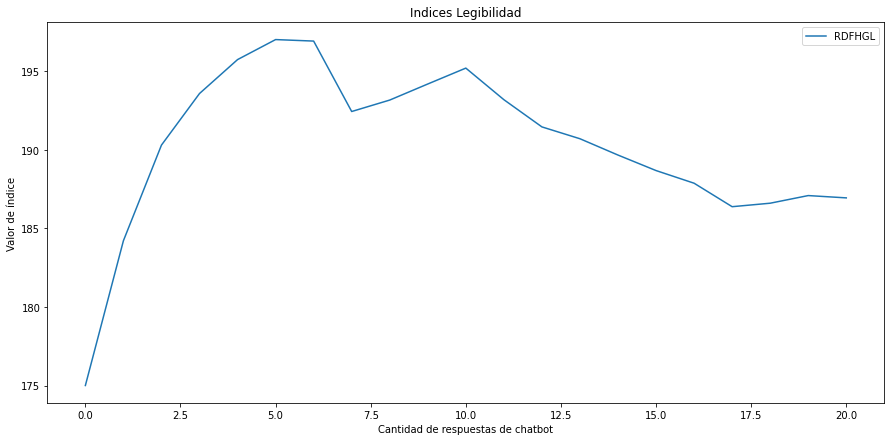

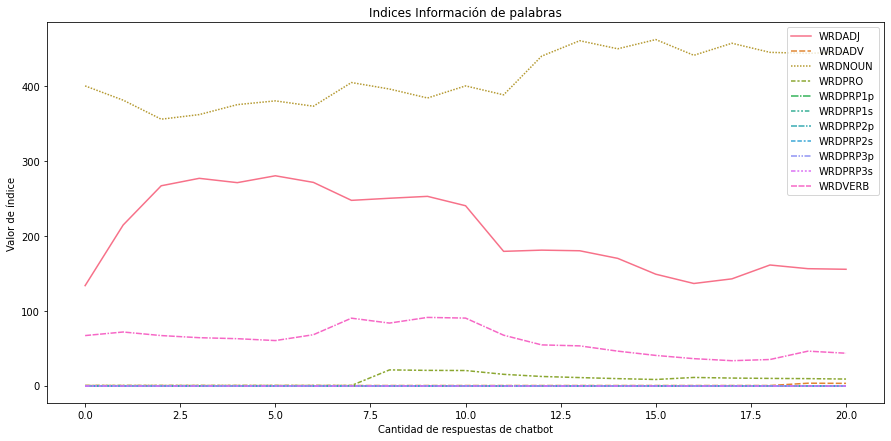

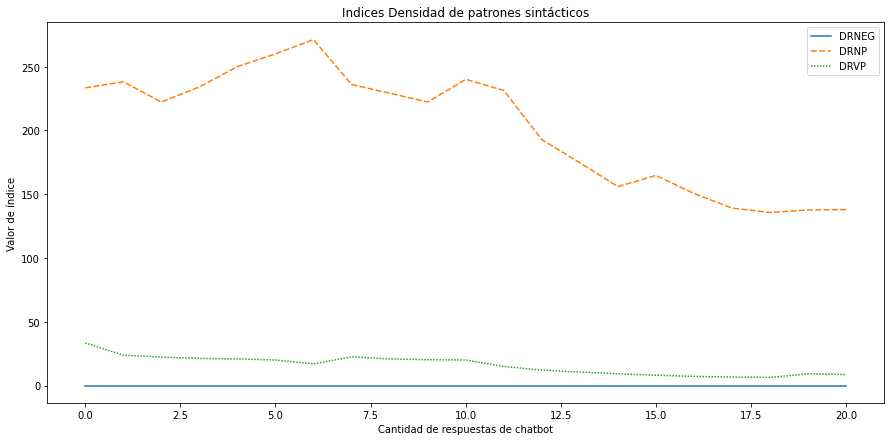

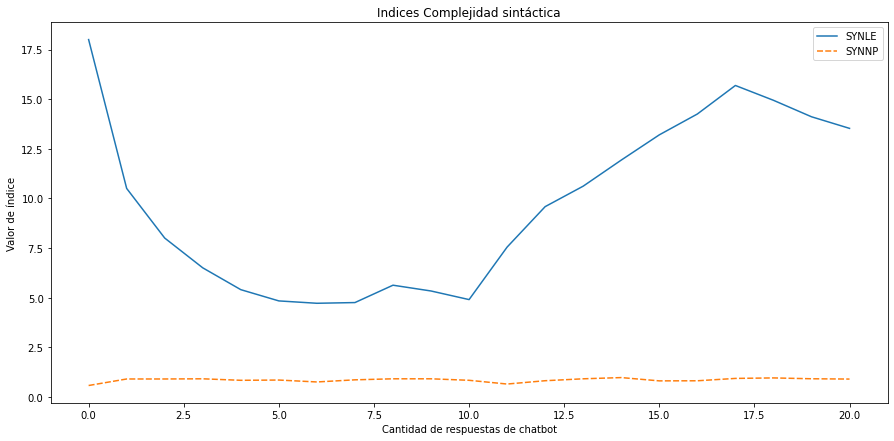

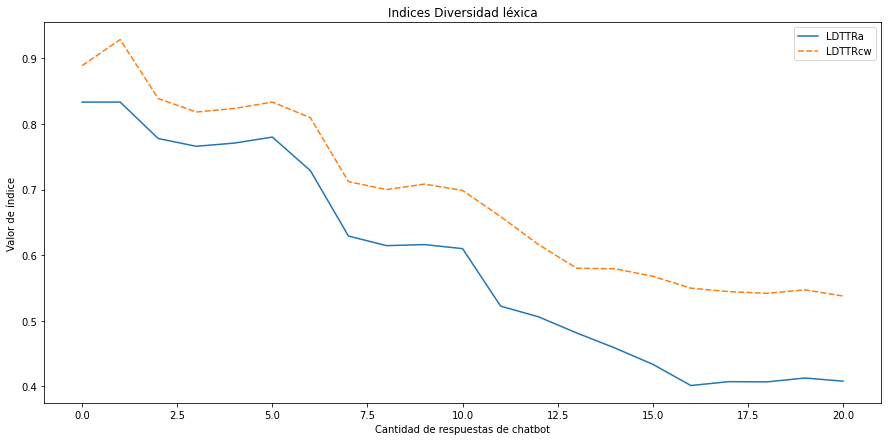

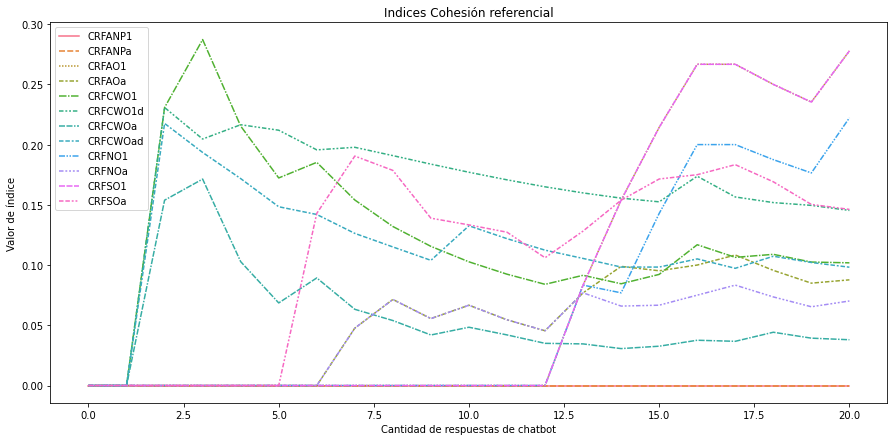

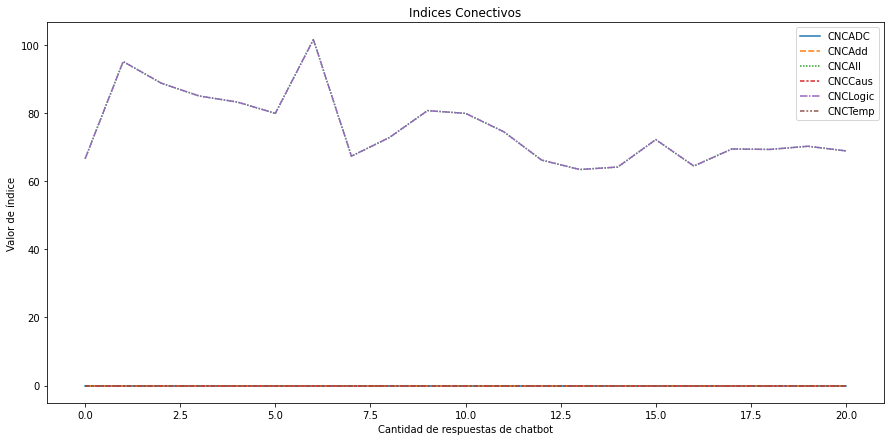

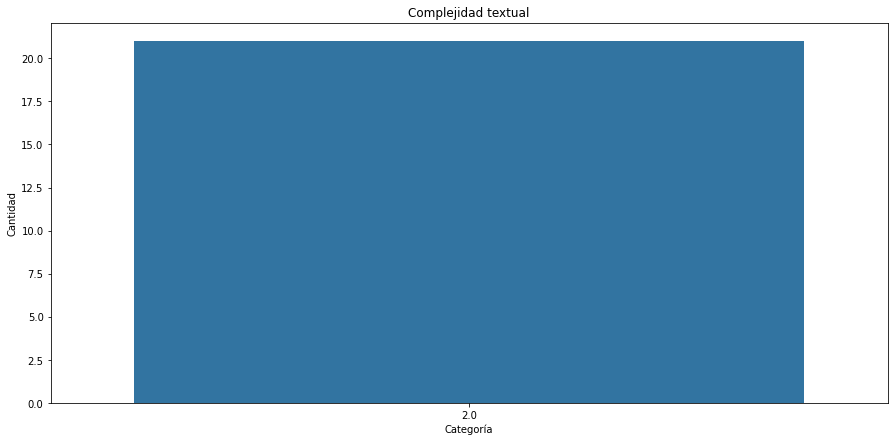

In [78]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \geq 1.5 \\
\ H_1 < 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [79]:
predicted_text_statistic_analysis_2(textual_complexity=2, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es inf.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 2.0.
La moda 2.0 es igual a la complejidad textual 2.
La exactitud de las predicciones es de 100.0%.


<ipython-input-51-2ee3bce81b18>:6: RuntimeWarning: divide by zero encountered in double_scalars
  z_0 = (total_mean - mean) / predictions['Categoria'].sem() # Calculate z test


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 2, la cual es la la complejidad textual más alta y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 2. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.


# Experimento usando los documentos de Historia

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [52]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_1_Hist_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,443.365964,3917.738912
std,680.032997,2516.727338
min,4.903749,1619.706113
25%,33.936814,2026.929105
50%,195.689286,2667.822832
75%,665.974142,5264.687228
max,6279.213420,11203.707172


#### Curva de error: Capacidad de comprensión

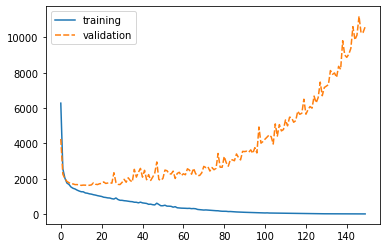

In [53]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [71]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_historia_150_chat.txt')
print(chatbot_responses)

['estimación a a y guardados pirámides pirámides barro emergen sipán a desérticas colinas bases besan y llanuras sembradas caña', 'josé', 'prohibida castigo quiso ricardo hija comienzan y educación a y y', 'grau quiso abandonar inca hija y orden san a orden a a dijimos dijimos concedido concedido concedido', 'y hombre quiso antiguos y y y y educación a a a a a a a carlos carlos carlos carlos ignacio contralmirante armada armada armada grau grau doña doña doña doña mariano mariano', 'y quiso o quiso documento y permiso educación educación educación y y', 'batalla y cusco inca inca y y a a orden a a a dijimos dijimos concedido concedido', 'josé y titu antiguos y y y y y a a a a a a a carlos carlos carlos carlos carlos contralmirante contralmirante contralmirante ignacio grau grau grau congreso congreso congreso congreso congreso mariano mariano mariano mariano mariano congreso congreso congreso hermano hermano hermano monarcas aprender aprender aprender república república república repú

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [72]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 7.341857194900513 seconds.
Text analyzed in 6.308426380157471 seconds.
Text analyzed in 7.087475538253784 seconds.
Text analyzed in 6.304643392562866 seconds.
Text analyzed in 7.259243488311768 seconds.
Text analyzed in 14.94121527671814 seconds.
Text analyzed in 13.286648035049438 seconds.
Text analyzed in 13.394258260726929 seconds.
Text analyzed in 13.144842624664307 seconds.
Text analyzed in 12.553399562835693 seconds.
Text analyzed in 12.675890922546387 seconds.
Text analyzed in 12.347579717636108 seconds.
Text analyzed in 12.772347211837769 seconds.
Text analyzed in 14.410840272903442 seconds.
Text analyzed in 13.030063152313232 seconds.
Text analyzed in 11.848134994506836 seconds.
Text analyzed in 13.844258308410645 seconds.
Text analyzed in 11.017860174179077 seconds.
Text analyzed in 8.726477861404419 seconds.
Text analyzed in 8.151215314865112 seconds.
Text analyzed in 7.626320123672485 seconds.
Text analyzed in 7.394629716873169 seconds.
Text analyzed in 7.4

#### Graficando los índices y complejidad textual

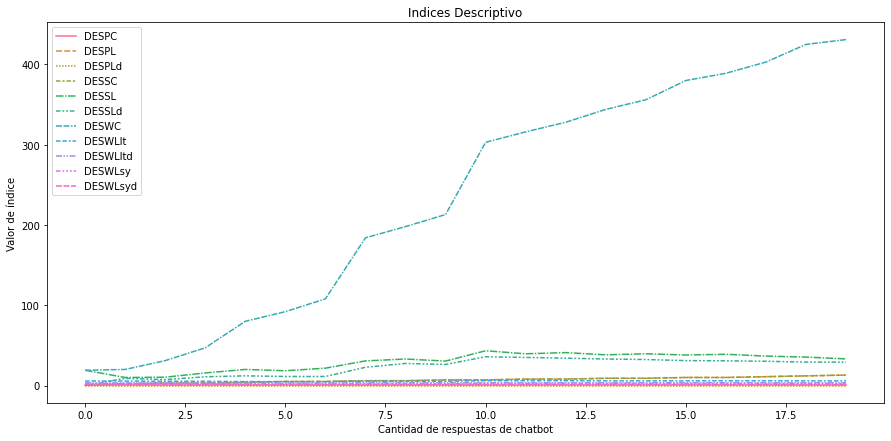

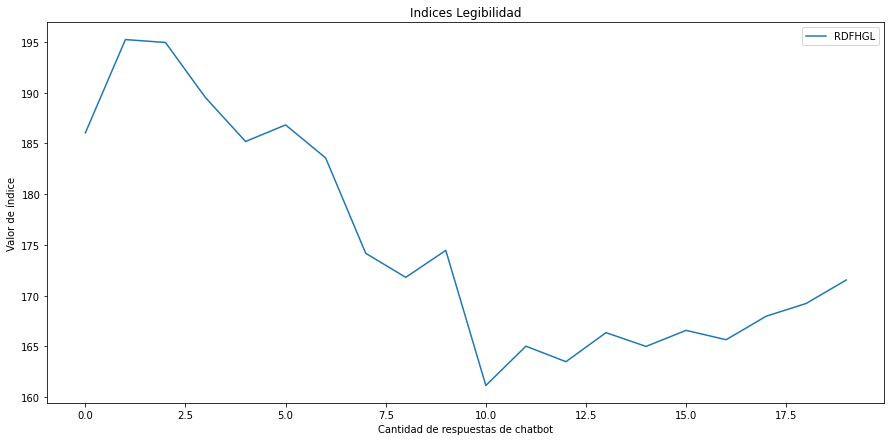

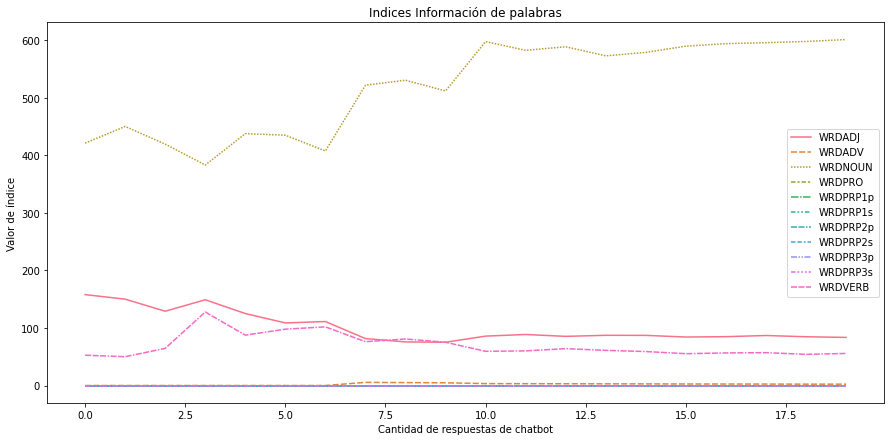

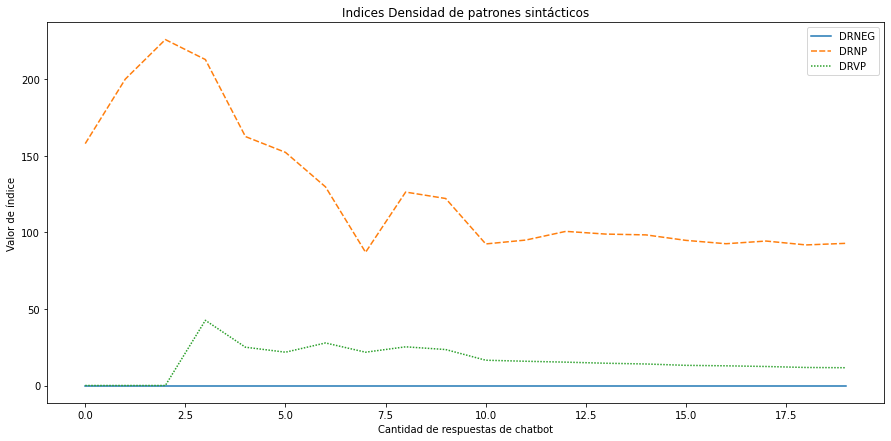

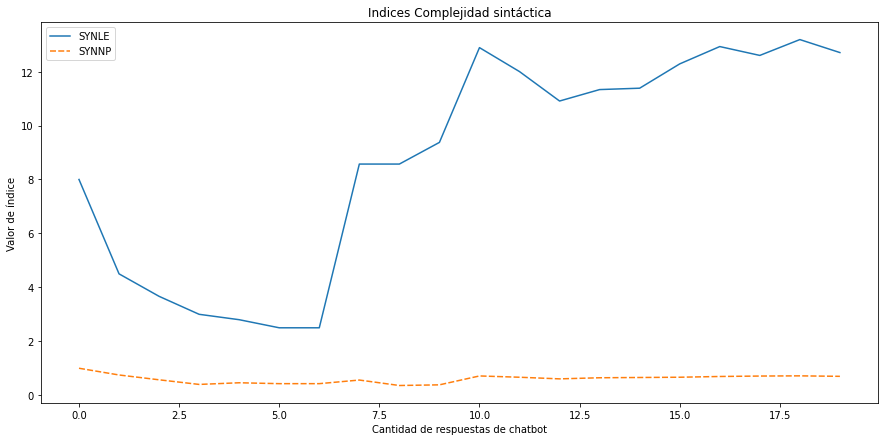

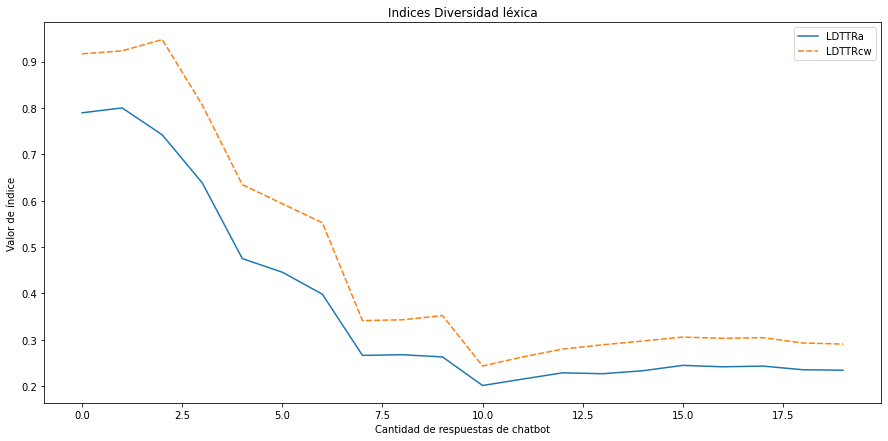

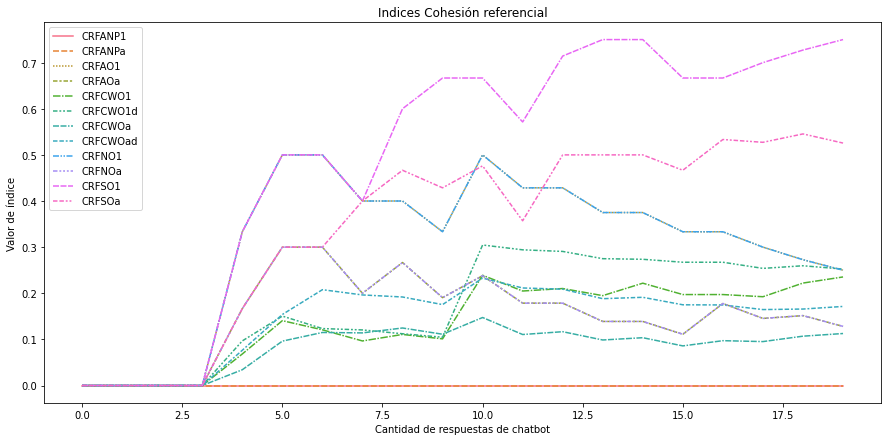

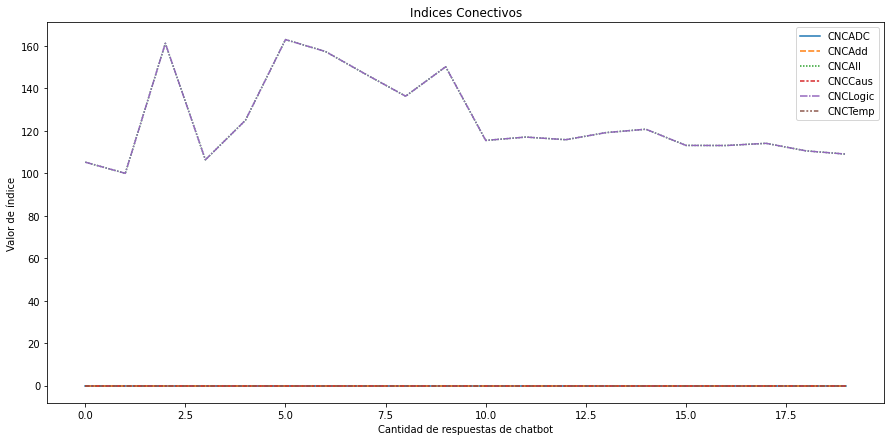

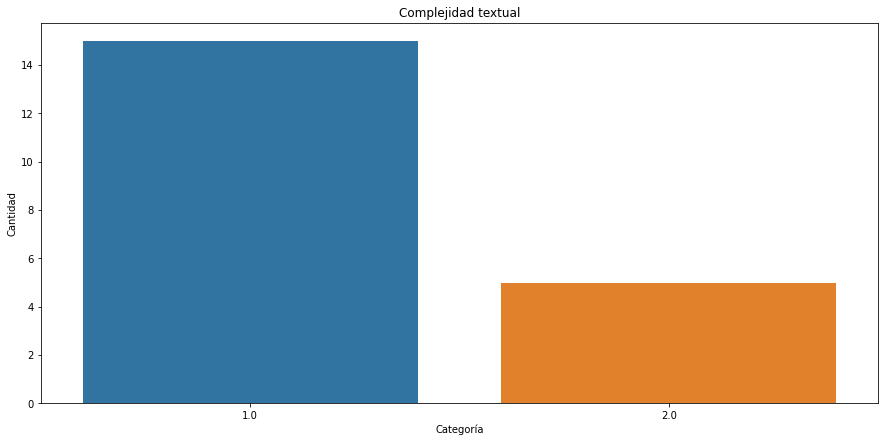

In [73]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \leq 1.5 \\
\ H_1 > 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [75]:
predicted_text_statistic_analysis_2(textual_complexity=1, predictions=indices['Complejidad textual'], mean=1.5, tail='upper', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es -2.516611478423583.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.25.
La moda 1.0 es igual a la complejidad textual 1.
La exactitud de las predicciones es de 75.0%.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 1, la cual es la la complejidad textual más alta y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 1. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [75]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_2_historia_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,1153.732201,14700.003441
std,1684.745632,11076.844983
min,170.374678,3080.970735
25%,319.258143,5763.224152
50%,621.114301,10142.665627
75%,1410.524610,21233.589717
max,13534.537083,51379.780574


#### Curva de error: Capacidad de comprensión

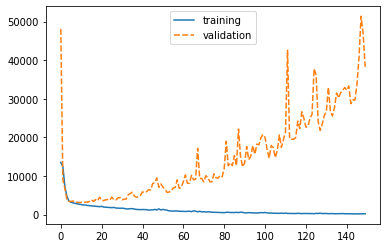

In [76]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [10]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_historia_150_chat.txt')
print(chatbot_responses)

['proyección y comenzó', 'proyección robinson manuel y tecnologia nap rey aprendizajes', 'josé y y y y siglo y y y y y y y y y y y y y y y a a a a y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y y', 'y y y y y y', 'y y y y y y y', 'y y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y', 'y y y y y y']


#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [11]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 7.5455873012542725 seconds.
Text analyzed in 7.894482374191284 seconds.
Text analyzed in 7.4323570728302 seconds.
Text analyzed in 7.4289820194244385 seconds.
Text analyzed in 7.455008268356323 seconds.
Text analyzed in 7.486141920089722 seconds.
Text analyzed in 7.50634503364563 seconds.
Text analyzed in 7.463989496231079 seconds.
Text analyzed in 7.479655981063843 seconds.
Text analyzed in 7.430379390716553 seconds.
Text analyzed in 7.4011335372924805 seconds.
Text analyzed in 7.434823751449585 seconds.
Text analyzed in 7.438943862915039 seconds.
Text analyzed in 7.4513020515441895 seconds.
Text analyzed in 7.7437334060668945 seconds.
Text analyzed in 7.40863823890686 seconds.
Text analyzed in 7.511809825897217 seconds.
Text analyzed in 7.451450347900391 seconds.
Text analyzed in 7.510678768157959 seconds.
Text analyzed in 7.426806449890137 seconds.
Text analyzed in 7.408740043640137 seconds.
Text analyzed in 7.492662668228149 seconds.
Text analyzed in 7.459321022033

#### Graficando los índices y complejidad textual

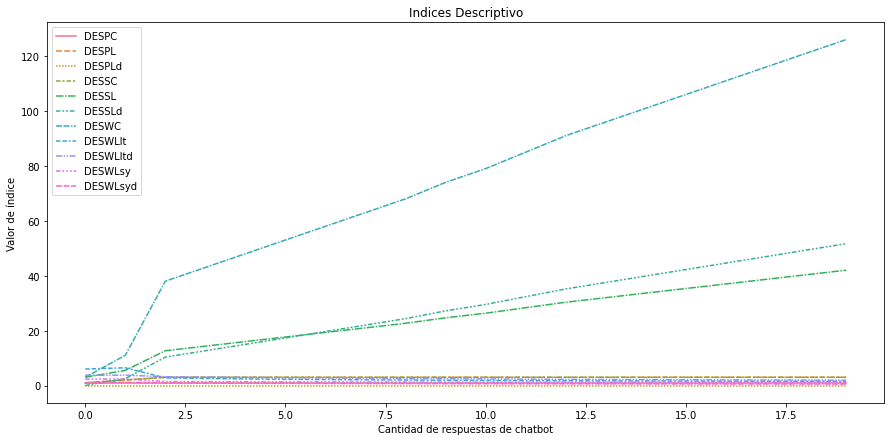

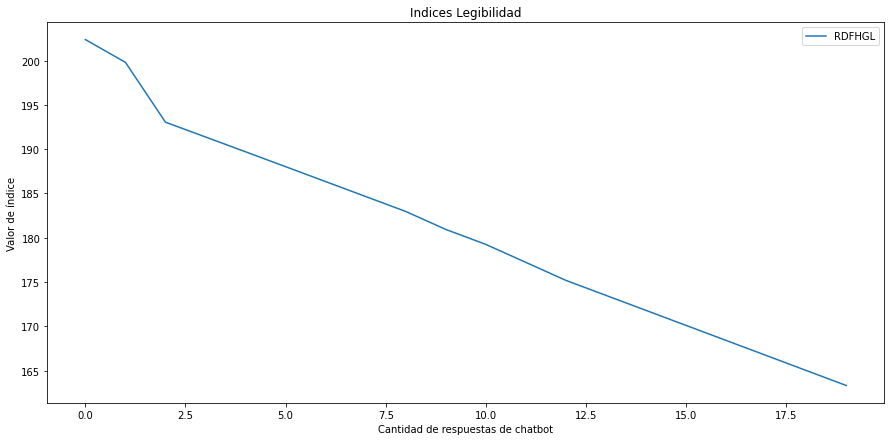

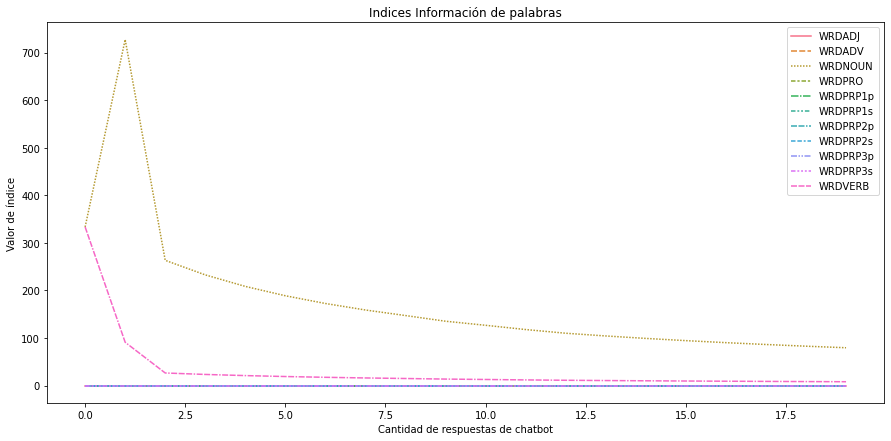

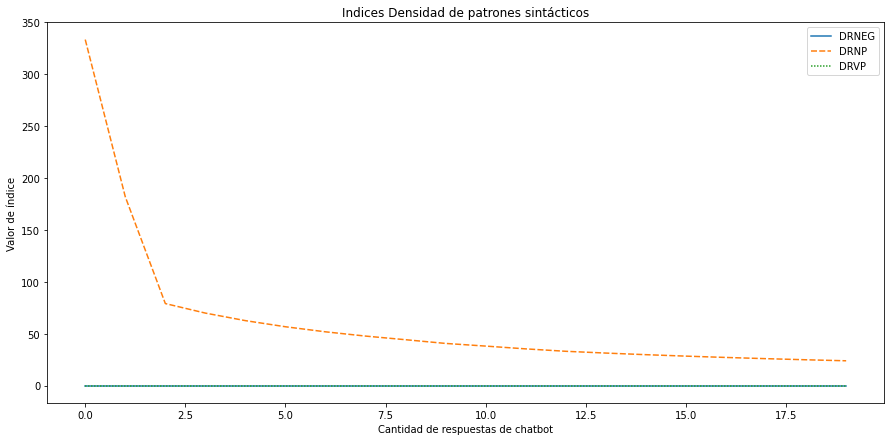

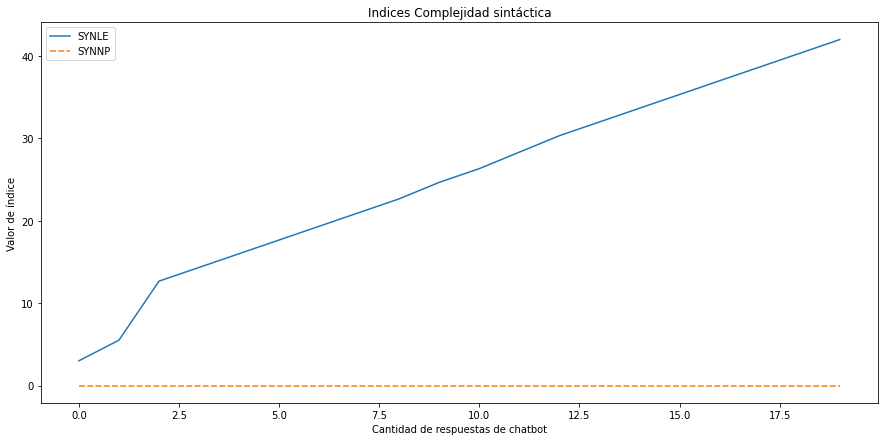

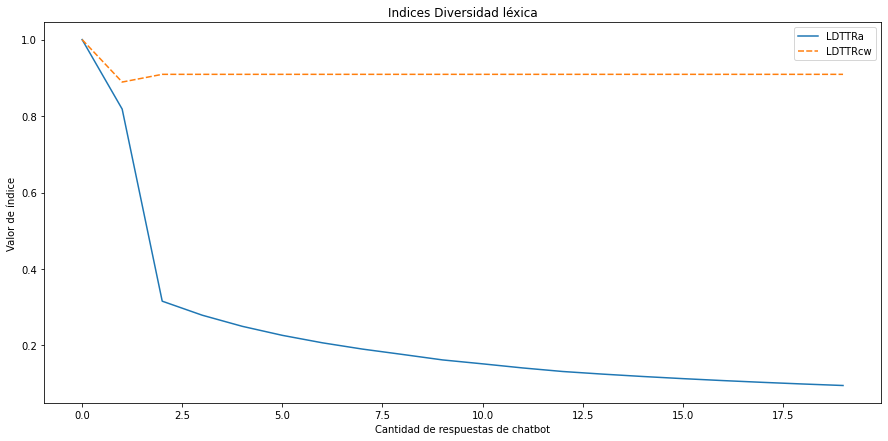

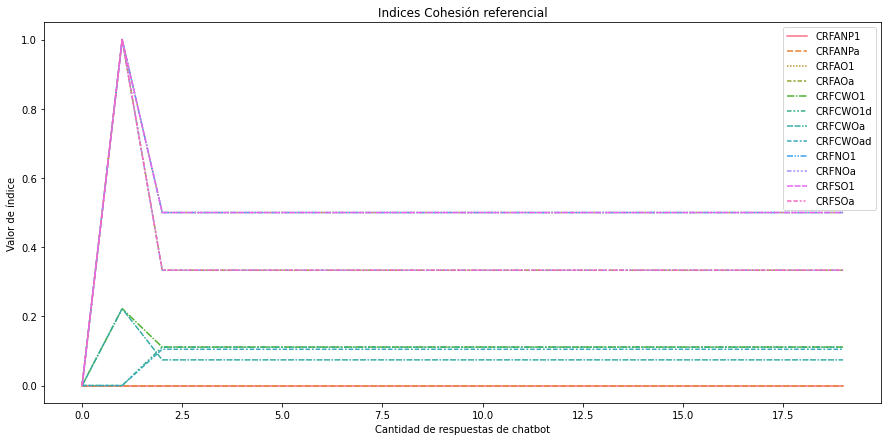

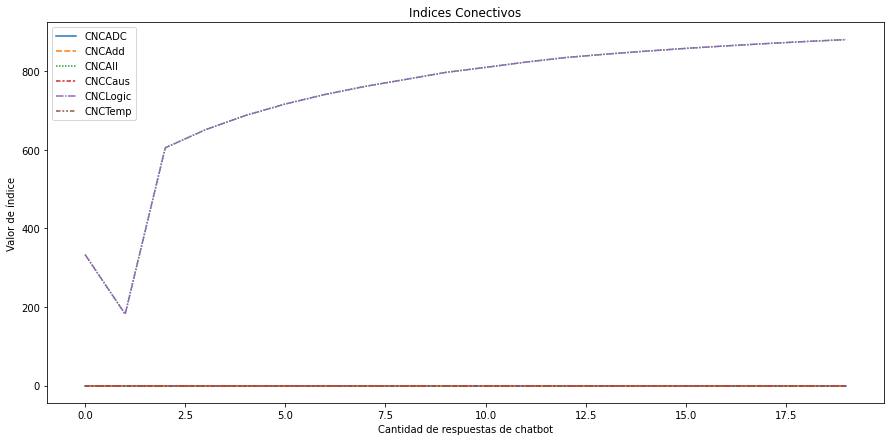

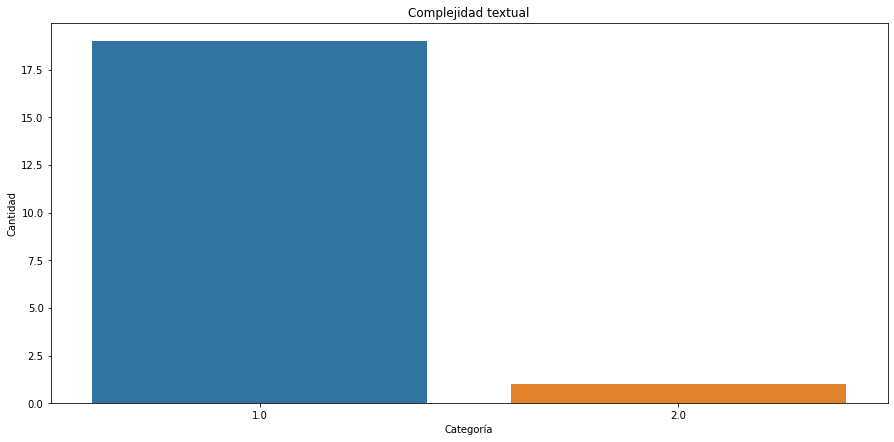

In [12]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \geq 1.5 \\
\ H_1 < 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [13]:
predicted_text_statistic_analysis_2(textual_complexity=2, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es -8.999999999999998.
Se rechaza la hipótesis nula. La media es 1.05
La moda 1.0 no es igual a la complejidad textual 2.
La exactitud de las predicciones es de 5.0%.


Se observa que, utilizando la moda para encontrar la clase más con las respuestas del chatbot, el nivel de complejidad textual encontrado es de 1, en vez de 2. Ello se debe a que las respuestas del chatbot no son adecuadas, ya que el conjunto de datos provisto no fue tan grande y con ello, el chatbot no pudo descubrir los patrones correctos en los datos para generar respuestas adecuadas.
